In [15]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [16]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20201021"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [17]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str22,str11,object,float64,int64,int64
BL_Lac-001B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lac-001R.fit,Light Frame,Bessel R,60.0,1024,1024
BL_Lac-001V.fit,Light Frame,Bessel V,60.0,1024,1024
Barnards_Star-001V.fit,Light Frame,Bessel V,20.0,1024,1024
Barnards_Star-002V.fit,Light Frame,Bessel V,20.0,1024,1024
Bias-001.fit,Bias Frame,--,0.0,1024,1024
Bias-002.fit,Bias Frame,--,0.0,1024,1024
Bias-003.fit,Bias Frame,--,0.0,1024,1024
Bias-004.fit,Bias Frame,--,0.0,1024,1024


In [18]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [19]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [20]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [21]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

798.9908037185669 1.4826
792.0 810.1135683529685


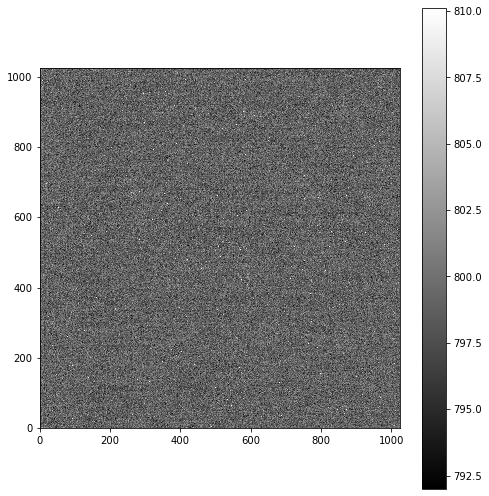

In [22]:
show_image(combined_bias)

0.2392689943313599 0.06177499999999998
0.03333333333333333 0.5675661809069259


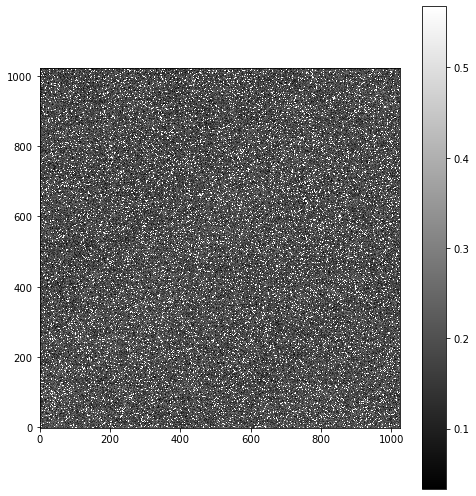

In [23]:
show_image(combined_darks)

0.9996277183338222 0.009661422026134096
0.9619616391708695 1.0266340079927807


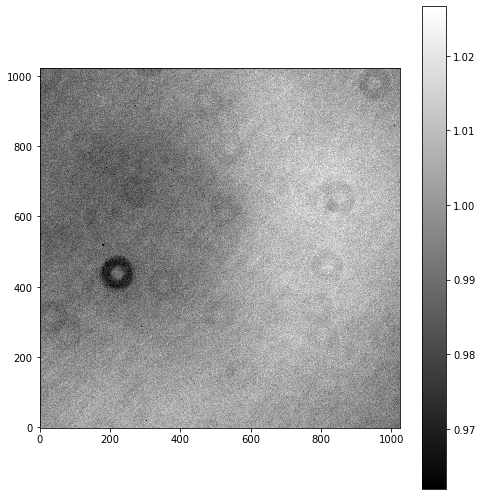

0.9995320192623345 0.008714474490981547
0.9668554134530899 1.0218028217814215


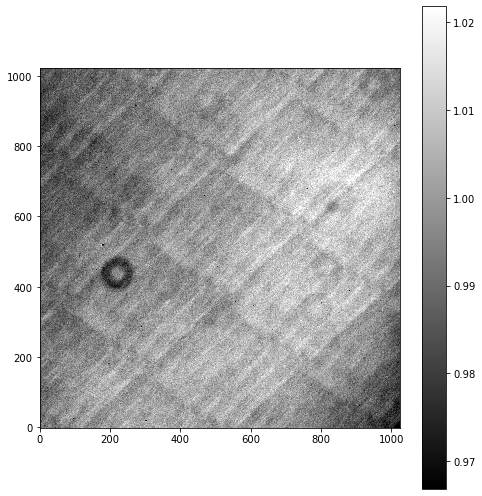

0.9998085214192493 0.007998904599250279
0.9727834362998831 1.0185973958796382


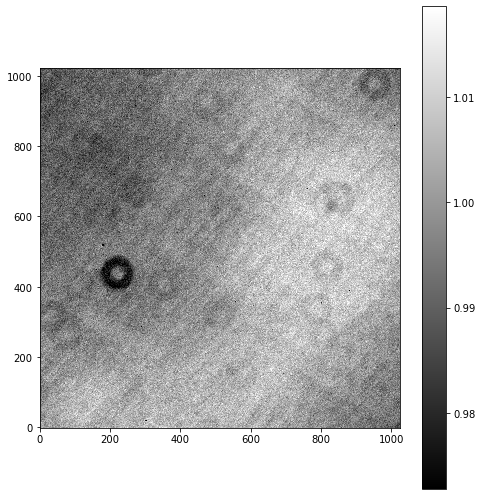

In [24]:
for filt,image in master_flats.items():
    show_image(image)

In [25]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
415.42248480529605 14.249182386023055
366.78654800595535 495.71601286722495


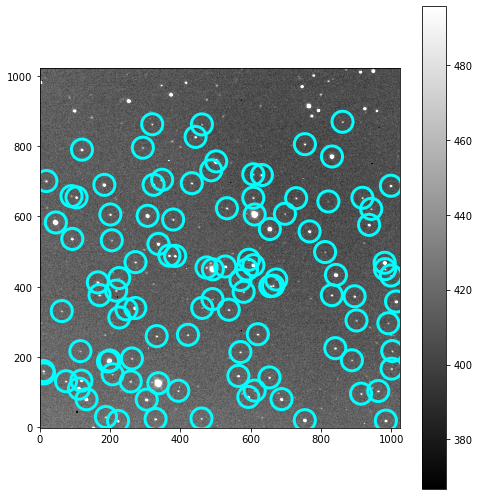

      xcentroid   ycentroid       mag
15   337.183535  125.640516 -6.971328
81   611.225468  605.570073 -6.587802
60   492.116973  449.746694 -6.372199
100  501.620607  756.811762 -4.798227
77    45.432373  583.006736 -4.782033
..          ...         ...       ...
43   461.864724  339.942902 -0.124841
56   225.898880  424.883241 -0.101678
85   820.812389  642.802786 -0.089988
36   991.382041  296.307692 -0.029163
90    89.917364  657.975515 -0.003761

[109 rows x 3 columns]
Point RA 23 41 50
Point Dec +44 10 45
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.45833333, 44.17916667)>
radecstr 355.458 44.1792
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.33069825817

In [29]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH_And*R.fit')

for path in pathlist:
    #show_image(Rimage)
    Rimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Rimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Rimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
319.92251115264526 12.775196671477117
280.66054369818346 396.77478880587023


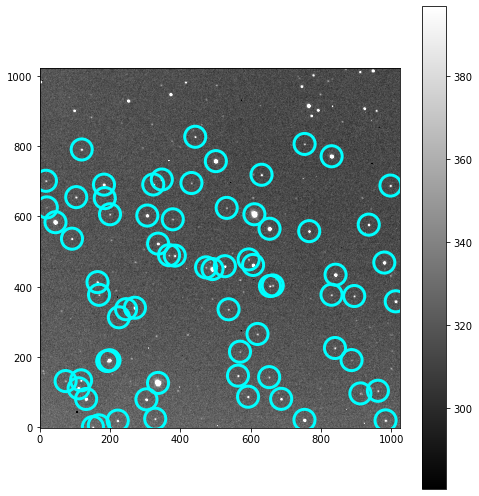

     xcentroid   ycentroid       mag
52  610.372502  606.319419 -6.185512
13  336.214417  126.480150 -5.902652
49   44.391803  583.759550 -4.365776
36  491.119021  450.474368 -4.359380
65  500.673859  757.509315 -4.329619
..         ...         ...       ...
21  569.321355  215.337278 -0.050288
43  367.463412  490.001244 -0.046706
10  911.934173   96.649669 -0.044445
61  431.239974  695.247546 -0.012483
55   19.740267  625.890781 -0.007393

[70 rows x 3 columns]
Point RA 23 41 50
Point Dec +44 10 45
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.45833333, 44.17916667)>
radecstr 355.458 44.1792
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.3306982581766   44.23592

In [30]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH_And*V.fit')

for path in pathlist:
    #show_image(Rimage)
    Vimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Vimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Vimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")